<a href="https://colab.research.google.com/github/eli-vigneron/toronto-parking-analysis/blob/main/toronto_parking_analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toronto Parking Infractions (#2)


In this notebook we will look at the following:

6. Analyze the impact of the following on all infractions:
* &ensp; Day of week
* &ensp; Month
* &ensp; Season (spring, summer, fall, winter)

The deliverables are the following:
* Impact of day of week on all infractions
* Impact of month on all infractions
* Impact of season on all infractions
* Distribution of infractions by year
* Distribution of infractions by month

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from itertools import groupby
from operator import itemgetter
import seaborn as sns
import csv
import sys
from sklearn.preprocessing import LabelEncoder
import re
import io
import requests
import json
%matplotlib inline

## Read and format the data

In [ ]:
# kaggle key (datasets are stored on kaggle)
data = {"username":"YOUR USERNAME","key":"YOUR KEY"}

with open('kaggle.json', 'w') as fp:
    json.dump(data, fp)

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d elivigneron/parking-tickets-data
! mkdir '../input'
! unzip '/content/parking-tickets-data.zip' -d '../input/parking-tickets-data/'

 99% 390M/395M [00:03<00:00, 132MB/s]
100% 395M/395M [00:03<00:00, 112MB/s]
Archive:  /content/parking-tickets-data.zip
  inflating: ../input/parking-tickets-data/parking-tickets-2008 (1)/Parking_Tags_data_2008.csv  
  inflating: ../input/parking-tickets-data/parking-tickets-2009/Parking_Tags_data_2009.csv  
  inflating: ../input/parking-tickets-data/parking-tickets-2010/Parking_Tags_data_2010.csv  
  inflating: ../input/parking-tickets-data/parking-tickets-2011 (1)/Parking_Tags_data_2011.csv  
  inflating: ../input/parking-tickets-data/parking-tickets-2012/Parking_Tags_Data_2012.csv  
  inflating: ../input/parking-tickets-data/parking-tickets-2013 (2)/parking-tickets-2013/Parking_Tags_Data_2013.csv  
  inflating: ../input/parking-tickets-data/parking-tickets-2014/Parking_Tags_Data_2014_1.csv  
  inflating: ../input/parking-tickets-data/parking-tickets-2014/Parking_Tags_Data_2014_2.csv  
  inflating: ../input/parking-tickets-data/parking-tickets-2014/Parking_Tags_Data_2014_3.csv  
  in

In [ ]:
def read_tickets(path, encode='utf-8'):
    pd.options.mode.chained_assignment = None  # default='warn'

    # bad_lines catches errors in formatting
    headers = ["tag_number_masked", "date_of_infraction", "infraction_code", 
               "infraction_description", "set_fine_amount", "time_of_infraction", 
               "location1","location2","location3", "location4", "province", "bad_lines"]

    df = pd.read_csv(path, 
                     encoding=encode,  # not sure why this encoding was used for 08/10 and not other years
                     quotechar='"', 
                     names=headers,
                     low_memory=False)
                     #skiprows=1)

    # there were some error lines condensed into the location2
    bad_lines_df = df[df.bad_lines.notnull()]
    
    corrupt_line_index = bad_lines_df.index[0]
    
    bad_lines_list = bad_lines_df.to_csv(header=None, index=False).strip('\n').split('\r\n')
    bad_lines_df_2 = pd.DataFrame(bad_lines_list)[0].str.split(pat=",", expand=True) 
    
    try:
        bad_lines_df_2.columns = headers
        
        # fixing the last line
        bad_lines_df_2.tail(1)['location2'] = bad_lines_df.tail(1)['location3']
        bad_lines_df_2.tail(1)['location3'] = ''
        bad_lines_df_2.tail(1)['province'] = bad_lines_df.tail(1)['bad_lines']
        # drop last col
        bad_lines_df_2.drop(['bad_lines'], axis=1, inplace=True)
    except ValueError:
        bad_lines_df_2.columns = headers[:-1]
    

    # drop last col
    #bad_lines_df_2.drop(['bad_lines'], axis=1, inplace=True)
    df.drop(['bad_lines'], axis=1, inplace=True)
    df.drop([0, corrupt_line_index], inplace=True)
  
    # stack the two data frames
    df_cleaned = pd.concat([df, bad_lines_df_2]).reset_index(drop=True)
    df_cleaned = df_cleaned.astype({'date_of_infraction': 'int32', 'infraction_code':'int32', 'set_fine_amount':'int32'})

    del df
    del bad_lines_df_2
    return df_cleaned

In [ ]:
tickets_2008 = read_tickets('../input/parking-tickets-data/parking-tickets-2008 (1)/Parking_Tags_data_2008.csv', 'UTF-16 LE')

# just get the cols we want
tickets_2008 = tickets_2008[['date_of_infraction', 'time_of_infraction', 'set_fine_amount']]

In [ ]:
tickets_2009 = read_tickets('../input/parking-tickets-data/parking-tickets-2009/Parking_Tags_data_2009.csv', 'utf-8')

# just get the cols we want
tickets_2009 = tickets_2009[['date_of_infraction', 'time_of_infraction', 'set_fine_amount']]

In [ ]:
tickets_2010 = read_tickets('../input/parking-tickets-data/parking-tickets-2010/Parking_Tags_data_2010.csv', 'UTF-16 LE')

# just get the cols we want
tickets_2010 = tickets_2010[['date_of_infraction', 'time_of_infraction', 'set_fine_amount']]

In [ ]:
# Get a list of csv files
csvs = []

for path, subdirs, files in os.walk("../input/parking-tickets-data"):
    for name in files:
        if name.lower().endswith('.csv'):
            csvs.append(os.path.join(path, name))

paths = [list(i) for j, i in groupby(csvs,
                  lambda a: a.split('_')[0])]


paths = sorted(paths, key=itemgetter(0))

years = {2008:tickets_2008, 2009: tickets_2009, 2010: tickets_2010}  # dictionary to contain the datafames with keys as the year

for i, path in enumerate(paths[3:]):
    key = i+2011
    value = pd.concat((pd.read_csv(f, quotechar='"', usecols=['date_of_infraction', 'time_of_infraction', 'set_fine_amount']) for f in path))
    years[key] = value

In [ ]:
# convert the first problematic years to numeric
for i in range(2008,2011):
    years[i]['time_of_infraction'] = pd.to_numeric(years[i]['time_of_infraction'],errors='coerce')
    years[i][['date_of_infraction', 'set_fine_amount']] = years[i][['date_of_infraction', 'set_fine_amount']].astype(float)

In [ ]:
for year in range(2008,2021):

    # add a datetime column, convert integer to datetime
    years[year]['date_of_infraction'] = pd.to_datetime(years[year].date_of_infraction.astype(str), format='%Y%m%d')
    years[year]['date_time_infraction'] = pd.to_datetime(years[year].date_of_infraction) + \
                                          pd.to_timedelta(years[year].time_of_infraction // 100, unit='H') + \
                                          pd.to_timedelta(years[year].time_of_infraction % 100, unit='T')
    
    # sort and reset the index 
    years[year] = years[year].sort_values(by='date_time_infraction',ascending=True).reset_index(drop=True)
    # we notice that there are some times missing, squish them together
    years[year]['date_time_infraction'].fillna(years[year]['date_of_infraction'], inplace=True)
    # drop time_of_infraction
    years[year].drop('time_of_infraction', inplace=True, axis=1)

Now we have the date and time formatted correctly so we can resample it as we like

In [ ]:
years[2008].head()

,date_of_infraction,set_fine_amount,date_time_infraction
0,2008-01-01,100.0,2008-01-01 00:01:00
1,2008-01-01,100.0,2008-01-01 00:03:00
2,2008-01-01,30.0,2008-01-01 00:04:00
3,2008-01-01,30.0,2008-01-01 00:05:00
4,2008-01-01,30.0,2008-01-01 00:05:00


## Time series of infractions by day

In [ ]:
# collect all the resampled data frames into a dictionary
daily_time_series_revenue = {}
for year in range(2008,2021):
    daily_time_series_revenue[year] = years[year].resample('D', on='date_of_infraction')['set_fine_amount'].sum().to_frame()

Lets look at the time series graphs for the revenues

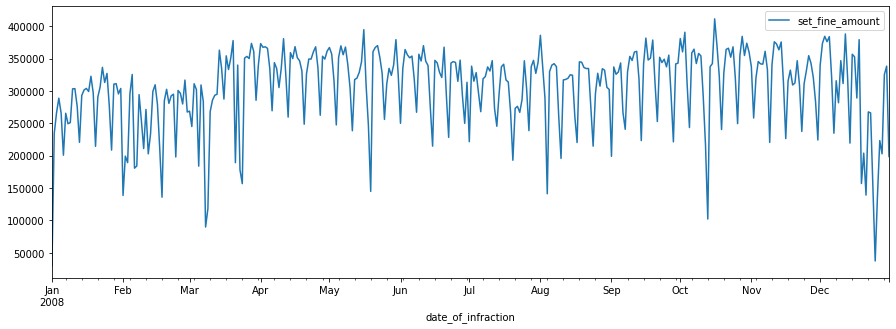

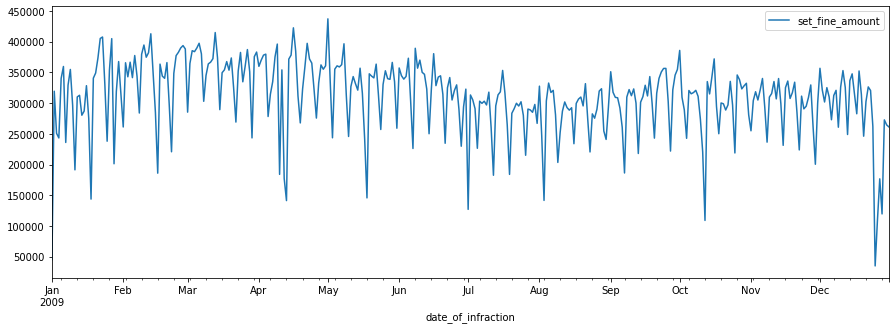

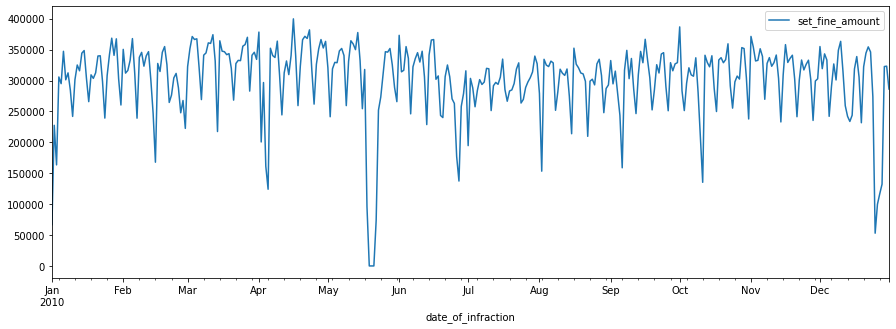

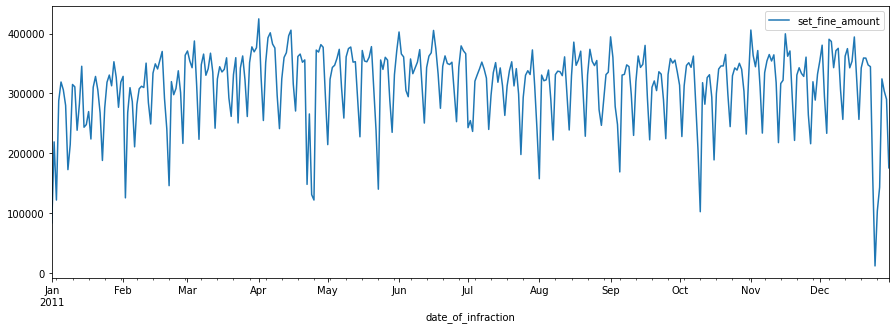

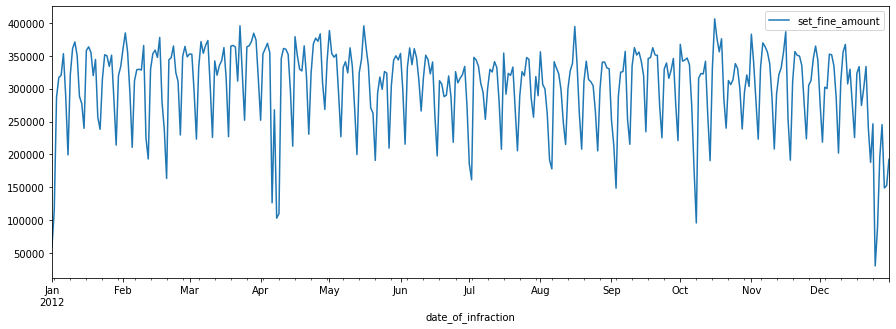

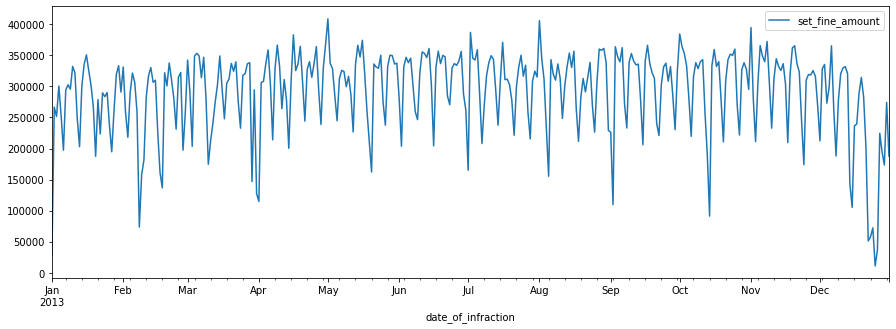

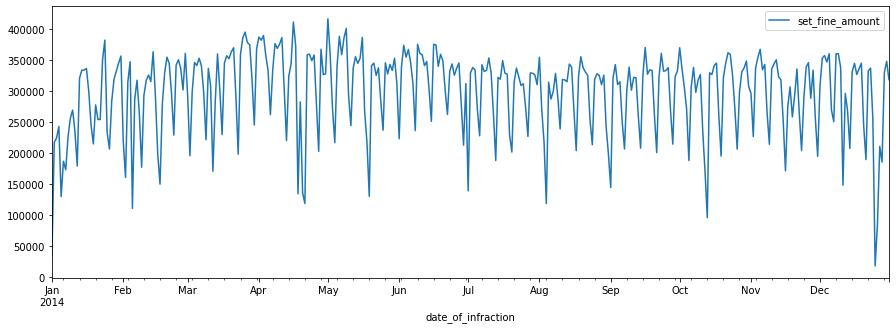

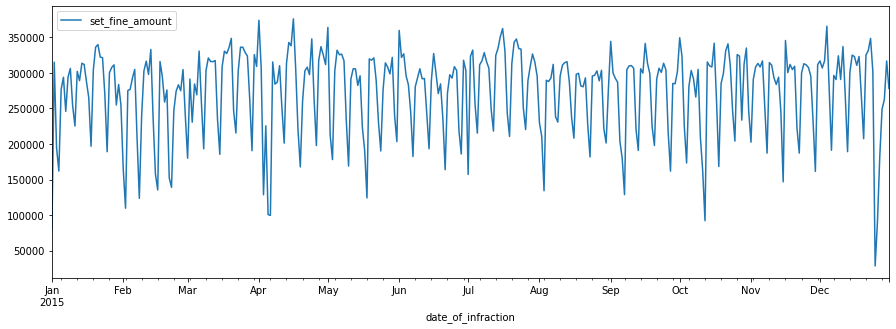

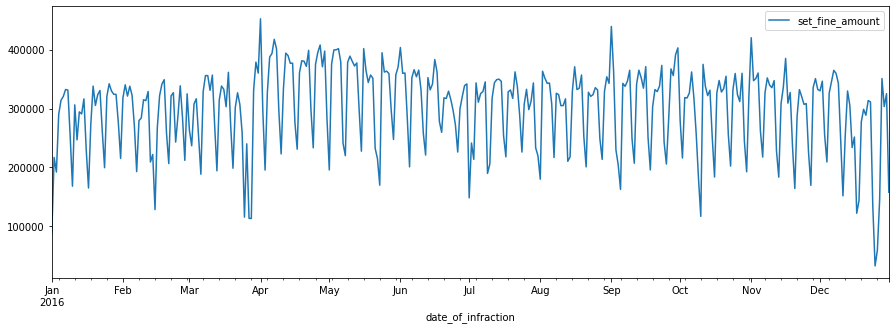

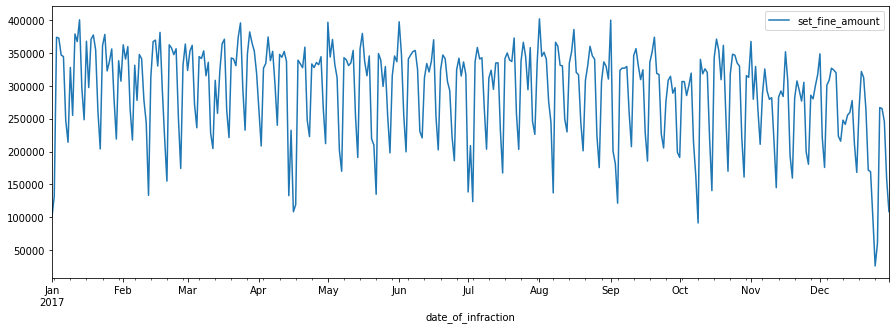

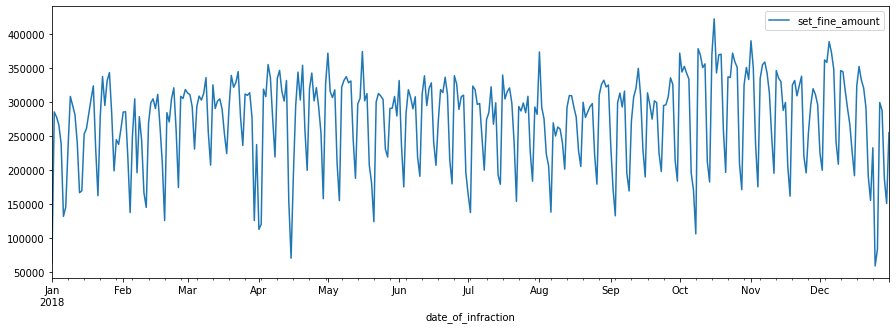

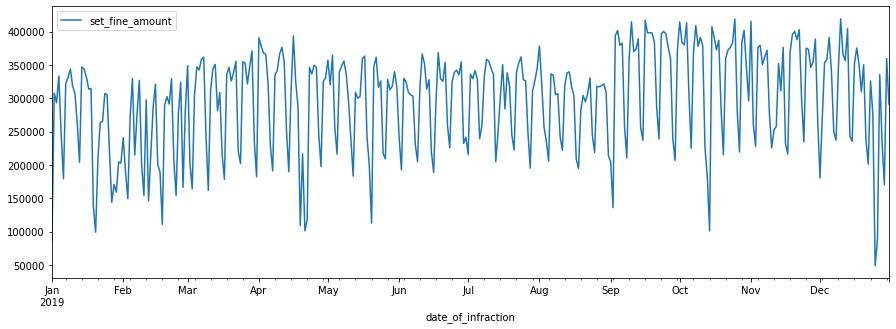

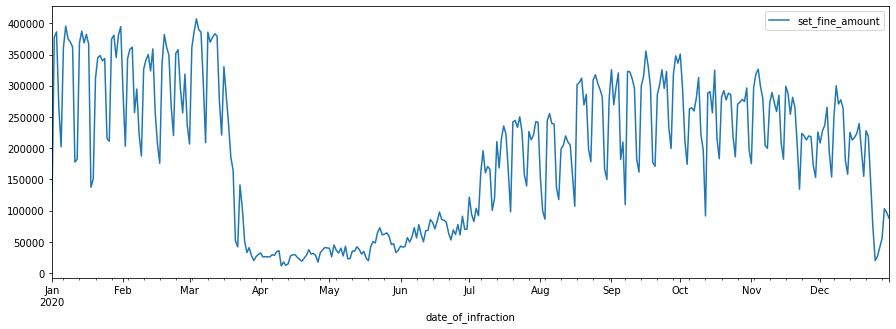

In [ ]:
for year in range(2008,2021):
    daily_time_series_revenue[year].plot(kind='line', figsize=(15,5));

## Time series of infractions by month

In [ ]:
monthly_time_series_rev = {}
# monthly_time_series_count = {}
for year in range(2008,2021):
    monthly_time_series_rev[year] = years[year].resample('M', convention='end', on='date_of_infraction')['set_fine_amount'].sum().to_frame()
    # monthly_time_series_count[year] = years[year].resample('M', convention='end', on='date_of_infraction')['set_fine_amount'].count().to_frame()

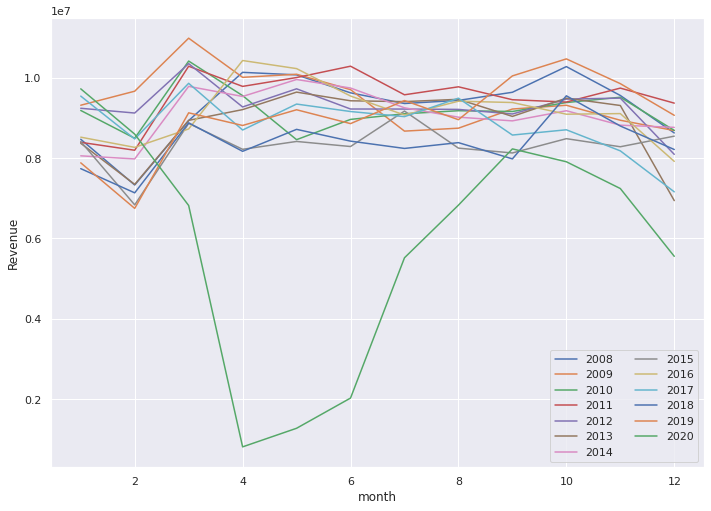

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
stacked_months = pd.concat(monthly_time_series_rev.values())
stacked_months['month'] = pd.DatetimeIndex(stacked_months.index).month
stacked_months['year'] = pd.DatetimeIndex(stacked_months.index).year
piv = pd.pivot_table(stacked_months, index=['month'], columns=['year'], values=['set_fine_amount'])
piv.plot()
plt.legend([year for year in range(2008, 2021)], ncol=2, loc='lower right')
plt.ylabel("Revenue");

As we can see from the graph (Fig.  3), 2020 is again an outlier, which is to be expected.  It is interesting to note that the graph representing 2020 closely tracks the timeline of the pandemic,  with the closure ofpublicly funded schools coming in March 2020 after the March break A  timeline  of  covid-19  in  ontario.https://globalnews.ca/news/6859636/ontario-coronavirus-timeline/, Mar 2021.  In the other years we see apattern of a peak in ticketing in March, perhaps corresponding to the March break.

### Distribution of infractions by month

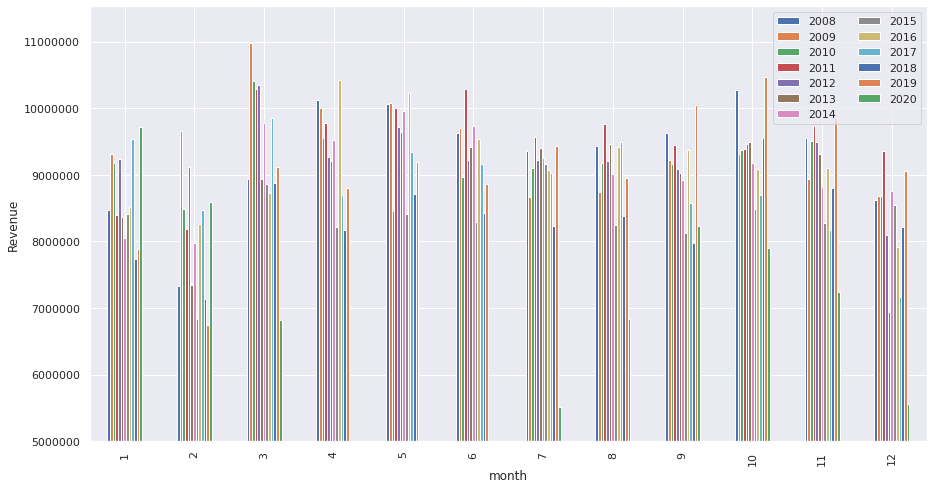

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
piv.plot(kind='bar')
plt.legend([year for year in range(2008, 2021)], ncol=2, loc='upper right')
plt.ylabel("Revenue");
plt.gca().set_ylim(bottom=0.5e7)
plt.ticklabel_format(style='plain', axis='y');

In [ ]:
# revenue per month by year
pd.options.display.float_format = '${:,.0f}'.format
piv['set_fine_amount']

year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
month,,,,,,,,,,,,,
1,"$8,466,705","$9,313,345","$9,183,255","$8,391,100","$9,237,430","$8,367,290","$8,055,305","$8,410,675","$8,519,150","$9,540,230","$7,736,405","$7,881,130","$9,720,650"
2,"$7,330,300","$9,661,985","$8,492,365","$8,193,855","$9,119,365","$7,345,425","$7,978,190","$6,836,030","$8,265,715","$8,474,385","$7,135,105","$6,748,600","$8,594,975"
3,"$8,932,045","$10,980,275","$10,411,450","$10,283,105","$10,347,485","$8,937,355","$9,782,100","$8,861,035","$8,723,315","$9,858,135","$8,875,475","$9,124,740","$6,820,345"
4,"$10,130,870","$10,006,635","$9,551,760","$9,781,715","$9,270,210","$9,204,500","$9,531,150","$8,217,365","$10,424,730","$8,696,825","$8,167,140","$8,809,955","$819,680"
5,"$10,068,485","$10,083,555","$8,457,020","$10,001,845","$9,721,450","$9,639,110","$9,952,790","$8,412,845","$10,223,945","$9,342,155","$8,713,265","$9,200,480","$1,281,900"
6,"$9,621,415","$9,701,175","$8,960,845","$10,283,645","$9,219,250","$9,423,610","$9,741,330","$8,286,675","$9,541,990","$9,156,875","$8,420,405","$8,856,030","$2,032,960"
7,"$9,356,265","$8,669,600","$9,100,735","$9,573,000","$9,218,055","$9,403,045","$9,249,455","$9,167,795","$9,070,130","$9,029,465","$8,239,205","$9,429,960","$5,520,715"
8,"$9,433,430","$8,742,840","$9,176,665","$9,771,250","$9,209,565","$9,460,490","$9,016,295","$8,246,625","$9,413,430","$9,488,535","$8,383,345","$8,953,430","$6,829,200"
9,"$9,635,300","$9,219,000","$9,157,875","$9,450,175","$9,095,720","$9,035,655","$8,924,520","$8,126,525","$9,380,745","$8,571,780","$7,979,300","$10,042,260","$8,227,990"


Lets take a look at the graph with 2020 excluded since the pandemic skews the data

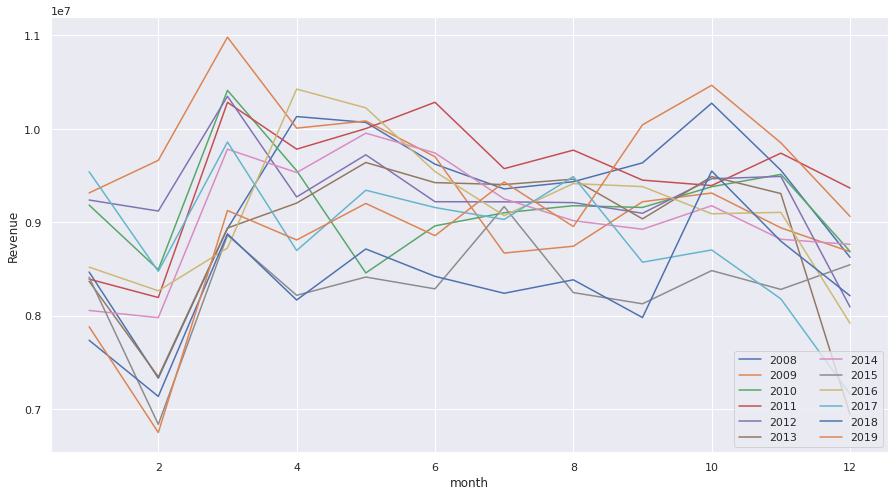

In [ ]:
keep_2020 = monthly_time_series_rev.pop(2020)
stacked_months_2 = pd.concat(monthly_time_series_rev.values())
stacked_months_2['month'] = pd.DatetimeIndex(stacked_months_2.index).month
stacked_months_2['year'] = pd.DatetimeIndex(stacked_months_2.index).year
piv = pd.pivot_table(stacked_months_2, index=['month'], columns=['year'], values=['set_fine_amount'])
piv.plot()
plt.legend([year for year in range(2008, 2020)], ncol=2, loc='lower right')
plt.ylabel("Revenue");

### Distribution and time series of infractions by season

In [ ]:
lookups = {
    11: 'Winter',
    12: 'Winter',
    1: 'Winter',
    2: 'Spring',
    3: 'Spring',
    4: 'Spring',
    5: 'Summer',
    6: 'Summer',
    7: 'Summer',
    8: 'Autumn',
    9: 'Autumn',
    10: 'Autumn'
}

season_time_series = {}
monthly_time_series_rev[2020] = keep_2020
for year in range(2008,2021):
    monthly_time_series_rev[year]['month'] = pd.DatetimeIndex(monthly_time_series_rev[year].index).month
    monthly_time_series_rev[year]['Season'] = monthly_time_series_rev[year]['month'].map(lookups)
    season_time_series[year] = monthly_time_series_rev[year][['set_fine_amount', 'Season']].groupby('Season').sum()

In [ ]:
season_time_series[2012]

,set_fine_amount
Season,
Autumn,27770430
Spring,28737060
Summer,28158755
Winter,26819320


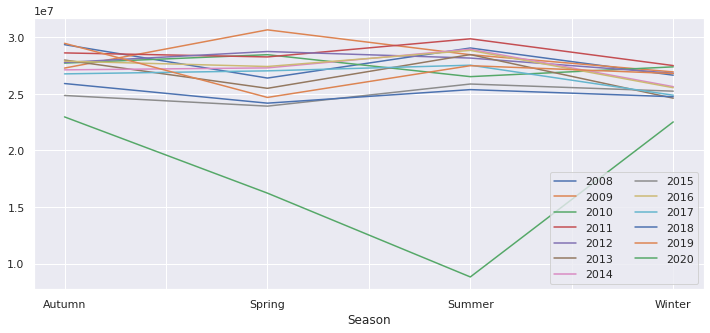

In [ ]:
ax = season_time_series[2008].plot(kind='line', figsize=(12,5))
for year in range(2009,2021):
    season_time_series[year].plot(kind='line', figsize=(12,5), ax=ax)
    
ax.legend([year for year in range(2008, 2021)], ncol=2, loc='lower right');

Let's see without 2020

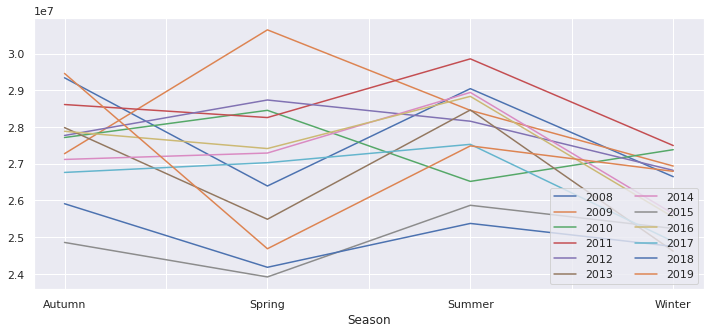

In [ ]:
keep_2020 = season_time_series.pop(2020)
ax = season_time_series[2008].plot(kind='line', figsize=(12,5))
for year in range(2009,2020):
    season_time_series[year].plot(kind='line', figsize=(12,5), ax=ax)
    
ax.legend([year for year in range(2008, 2020)], ncol=2, loc='lower right');

In [ ]:
# create a pivot table for the seasons
season_time_series[2020] = keep_2020
for year in range(2008,2021):
    season_time_series[year]['year_col'] = year
    
stacked_seasons = pd.concat(season_time_series.values())
season_piv = pd.pivot_table(stacked_seasons, index=['Season'], columns=['year_col'], values=['set_fine_amount'])
season_piv['set_fine_amount']

year_col,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Season,,,,,,,,,,,,,
Autumn,"$29,342,580","$27,274,045","$27,714,430","$28,613,775","$27,770,430","$27,984,935","$27,117,095","$24,855,120","$27,884,325","$26,763,035","$25,910,420","$29,461,175","$22,964,840"
Spring,"$26,393,215","$30,648,895","$28,455,575","$28,258,675","$28,737,060","$25,487,280","$27,291,440","$23,914,430","$27,413,760","$27,029,345","$24,177,720","$24,683,295","$16,235,000"
Summer,"$29,046,165","$28,454,330","$26,518,600","$29,858,490","$28,158,755","$28,465,765","$28,943,575","$25,867,315","$28,836,065","$27,528,495","$25,372,875","$27,486,470","$8,835,575"
Winter,"$26,646,785","$26,937,115","$27,383,000","$27,495,655","$26,819,320","$24,616,200","$25,635,230","$25,235,905","$25,541,835","$24,879,185","$24,745,680","$26,793,230","$22,519,935"


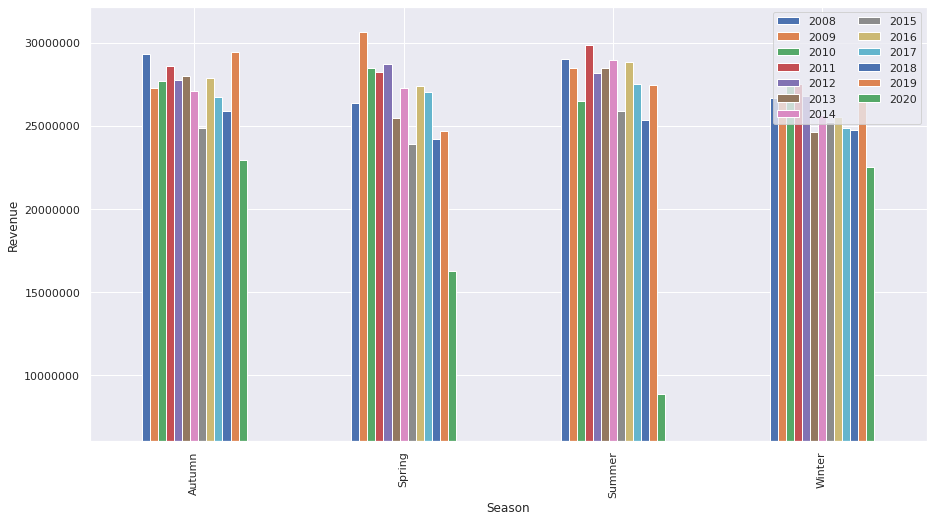

In [ ]:
season_piv.plot(kind='bar')
plt.legend([year for year in range(2008, 2021)], ncol=2, loc='upper right')
plt.ylabel("Revenue");
plt.gca().set_ylim(bottom=0.6e7)
plt.ticklabel_format(style='plain', axis='y');

It's sort of hard to distinguish with this many colours, can plot individually (if desired) with the below cell.
From the graph we see that Autum and Summer generally produce the most revenue.

In [ ]:
# for year in range(2008,2021):
#     season_time_series[year].plot(kind='line', figsize=(12,5))

### Distribution of infractions by day

In [ ]:
day_of_week = {}

for year in range(2008,2021):
    years[year]['weekday'] = years[year]['date_time_infraction'].apply(lambda x: x.weekday())
    day_of_week[year] = years[year][['weekday', 'set_fine_amount']].groupby('weekday').sum()

In [ ]:
# create a pivot table for the days
for year in range(2008,2021):
    day_of_week[year]['year'] = year
    
stacked_days = pd.concat(day_of_week.values())
days_piv = pd.pivot_table(stacked_days, index=['weekday'], columns=['year'], values=['set_fine_amount'])
days_piv['set_fine_amount']

year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
weekday,,,,,,,,,,,,,
0,"$15,718,980","$15,638,085","$15,118,750","$15,514,540","$15,620,390","$14,485,730","$15,638,925","$14,217,435","$15,492,690","$14,942,605","$14,470,780","$15,703,290","$10,441,645"
1,"$17,148,770","$17,552,620","$16,546,405","$17,779,735","$17,320,255","$17,034,560","$17,358,365","$16,077,845","$17,657,820","$17,100,830","$16,212,700","$17,926,460","$11,473,205"
2,"$16,945,280","$16,810,080","$16,660,595","$17,541,765","$17,507,380","$16,717,325","$17,004,580","$16,026,115","$17,559,265","$17,484,780","$16,102,960","$17,105,740","$11,419,505"
3,"$17,061,950","$17,395,460","$16,730,995","$17,935,240","$17,628,620","$16,585,285","$16,861,760","$15,951,900","$17,602,380","$16,995,585","$16,223,850","$17,133,530","$11,282,310"
4,"$17,249,905","$17,706,635","$17,259,975","$18,248,960","$17,541,570","$16,895,080","$17,137,060","$15,776,225","$17,752,945","$17,124,015","$15,986,445","$17,751,840","$11,288,055"
5,"$15,278,580","$15,844,020","$15,239,795","$15,232,940","$14,539,120","$13,949,505","$14,126,530","$12,186,025","$13,259,960","$12,428,070","$11,774,245","$12,425,130","$7,855,225"
6,"$12,025,280","$12,367,485","$12,515,090","$11,973,415","$11,328,230","$10,886,695","$10,860,120","$9,637,225","$10,350,925","$10,124,175","$9,435,715","$10,378,180","$6,795,405"


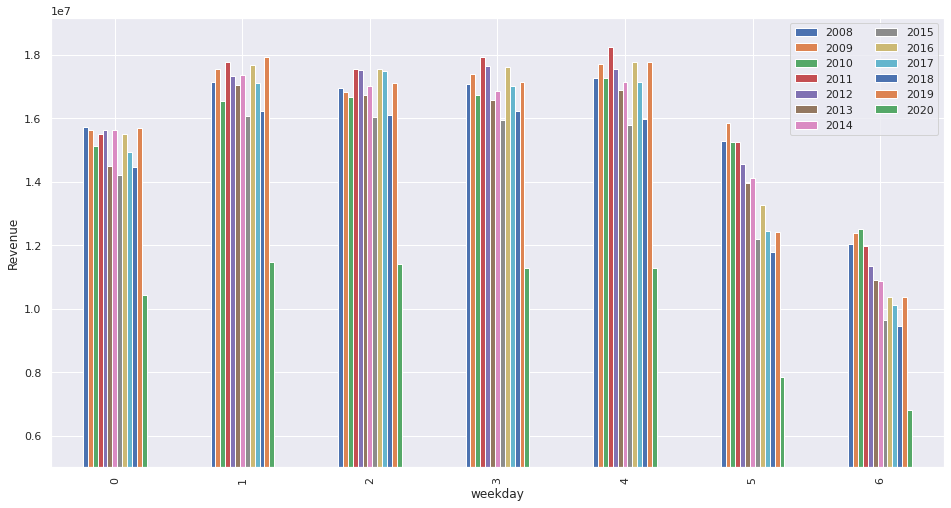

In [ ]:
sns.set(rc={'figure.figsize':(16,8.27)})
days_piv.plot(kind='bar')
plt.legend([year for year in range(2008, 2021)], ncol=2, loc='upper right')
plt.ylabel("Revenue")
plt.gca().set_ylim(bottom=0.5e7);

### Distribution of infractions by year

In [ ]:
days_piv['set_fine_amount'].sum().to_frame().transpose()

year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,"$111,428,745","$113,314,385","$110,071,605","$114,226,595","$111,485,565","$106,554,180","$108,987,340","$99,872,770","$109,675,985","$106,200,060","$100,206,695","$108,424,170","$70,555,350"


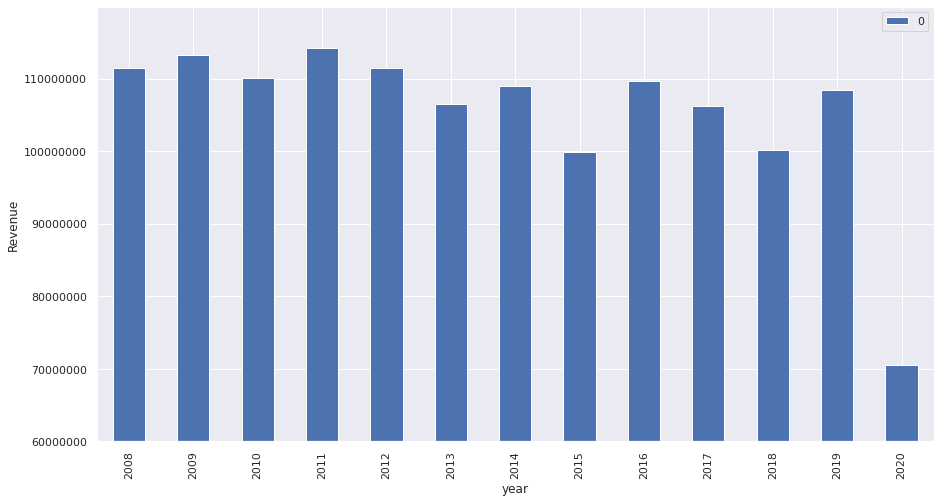

In [ ]:
days_piv['set_fine_amount'].sum().to_frame().plot(kind='bar');
plt.ylabel("Revenue");
plt.gca().set_ylim(bottom=6e7)
plt.ticklabel_format(style='plain', axis='y');